In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile
import scipy
from scipy import signal
import math
import pandas as pd
from datetime import datetime
import timeit
import time

In [2]:
# Helper functions for Convolving Waves
def convolveWaves(wave1, wave2,domain = "frequency"):
    # pad waves to avoid periodicity issues
    N = len(wave1)
    i    = 0
    plen = 1
    while plen < N:
        i += 1
        plen = 2 ** i
    wave1 = np.pad(wave1,(0,plen-N),'constant')
    wave2 = np.pad(wave2,(0,plen-N),'constant')
    if domain == "frequency":
        hs1 = np.fft.rfft(wave1)
        hs2 = np.fft.rfft(wave2)
        hs = hs1 * hs2
        hs = np.fft.irfft(hs)
    else:
        hs = signal.fftconvolve(wave1,wave2)
    return hs

def shiftedScale(wave,ts,shift = 1,factor = 0.5):
    N = len(wave)
    sswave   = np.zeros((N,))
    idxshift = np.argmax(ts > (ts[0] + shift))
    sswave[:idxshift]  = wave[:idxshift]*factor
    sswave = np.roll(sswave,idxshift)*factor
    return sswave

# Helper function for generating waves
def genSawToothWave(amp = 1,freq = 1,off = 0,dur = 1,frate = 10000):
    if off < 0:
        print("ERROR: Offset must be greater than 0")
        return
    # Generate SawTooth waveform
    nframes   = int((frate/freq)+1)
    tempwav1  = np.linspace(-amp,amp,nframes)
    tempwav   = tempwav1[:nframes-1]
    # Shift to offset
    startidx = 0
    startidx += int(len(tempwav)*off)
    wavend   = tempwav[:startidx]
    wavstart = tempwav[startidx:]
    wavcycle = np.append(wavstart,wavend)
    # Extend by duration and eliminate consecutive dups
    nwavs,wavfrac = divmod(dur,1/freq)
    wavextended1  = np.tile(wavcycle,int(nwavs))
    wavextended2  = wavcycle[:int(wavfrac*len(wavcycle))]
    wavout = np.append(wavextended1,wavextended2)
    ts2 = np.arange(0,dur,1/frate)
    # Generate Timestamps
    ts         = np.linspace(0,dur,len(wavout))
    #print(2*nframes,len(ts),len(ts2))
    return ts,wavout

def genTriangleWave(amp = 1,freq = 1,off = 0,dur = 1,frate = 10000):
    if off < 0:
        print("ERROR: Offset must be greater than 0")
        return
    # Generate Triangle waveform
    nframes   = int((frate/(2*freq))+1)
    tempwav1  = np.linspace(-amp,amp,nframes)
    tempwav2  = np.linspace(amp,-amp,nframes)
    tempwav   = np.append(tempwav1[:nframes-1],tempwav2[:nframes-1])
    # Shift to offset
    startidx = np.argmax(tempwav >= 0)  
    startidx += int(len(tempwav)*off)
    wavend   = tempwav[:startidx]
    wavstart = tempwav[startidx:]
    wavcycle = np.append(wavstart,wavend)
    # Extend by duration and eliminate consecutive dups
    nwavs,wavfrac = divmod(dur,1/freq)
    wavextended1  = np.tile(wavcycle,int(nwavs))
    wavextended2  = wavcycle[:int(wavfrac*len(wavcycle))]
    wavout = np.append(wavextended1,wavextended2)
    ts2 = np.arange(0,dur,1/frate)
    # Generate Timestamps
    ts         = np.linspace(0,dur,len(wavout))
    return ts,wavout

# Helper Function for converting waves to fft power spectrums back and forth
def make_spectrum(datain, ratein,mode='open'):
    n = len(datain)
    if mode == 'full':
        hsout    = np.fft.fft(datain)
        freq     = np.fft.fftfreq(n, d=1./ratein)
        sortidx  = sorted(range(len(freq)), key=lambda k: freq[k])
        hsout = hsout[sortidx]
        freq  = freq[sortidx]
    else:
        # power spectral density
        hsout = np.fft.rfft(datain)
        # frequency spectrum
        freq = np.fft.rfftfreq(n, d=1./ratein)
    return hsout, freq

def make_wave(hsin):
    wave = np.fft.irfft(hsin)
    return wave

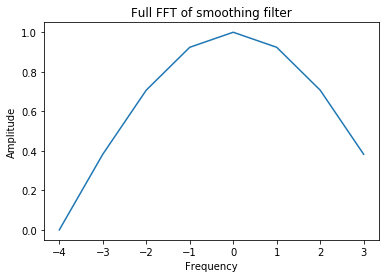

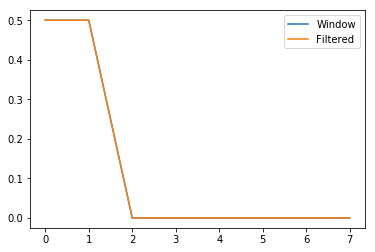

impulse response is identical to the convolution window that characterizes the system.


In [3]:
# impulse
from operator import itemgetter
impulse = np.zeros((8,))
impulse[0] = 1
impulse_spec = np.fft.fft(impulse)

win = np.full((2,),0.5)
win = np.pad(win,(0,6),'constant')
win_spec,fq = make_spectrum(win,8,mode='full')
plt.plot(fq,np.abs(win_spec))
plt.title('Full FFT of smoothing filter')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()
filtered = impulse_spec * win

plt.plot(win)
plt.plot(np.abs(filtered))
plt.legend(['Window','Filtered'])
plt.show()
print('impulse response is identical to the convolution window that characterizes the system.')


/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


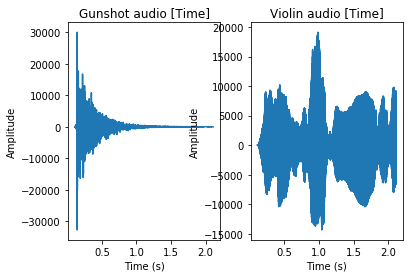

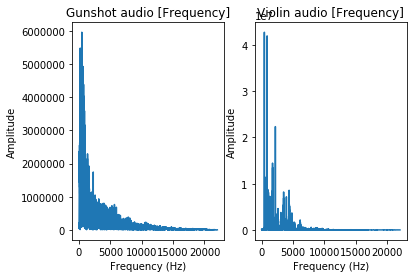

In [4]:
# Load gunshot
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/SampleAudioFiles/'
fname      = datafolder + '180960__kleeb__gunshot.wav'
rate, data = scipy.io.wavfile.read(fname,'r')
ts   = np.arange(0,len(data)) * 1/rate
# Take segment of audio file
lts  = np.all([ts >= 0.11,ts <= 2.11],axis = 0)
seg_data = data[lts,0]
seg_ts   = ts[lts]
# convert to Frequency domain
seg_spec,seg_freq = make_spectrum(seg_data, rate)
# Load Violin
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/SampleAudioFiles/'
fname      = datafolder + '92002__jcveliz__violin-origional.wav'
vrate, vdata = scipy.io.wavfile.read(fname)
vts   = np.arange(0,len(vdata)) * 1/vrate
# Take segment of audio file
lts  = np.all([vts >= 0.11,vts <= 2.11],axis = 0)
seg_vdata = vdata[lts]
seg_vts   = vts[lts]
# convert to Frequency domain
seg_vspec,seg_vfreq = make_spectrum(seg_vdata, vrate)
# Visualize
plt.subplot(121)
plt.plot(seg_ts,np.real(seg_data))
plt.title('Gunshot audio [Time]')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.subplot(122)
plt.plot(seg_vts,np.real(seg_vdata))
plt.title('Violin audio [Time]')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
plt.subplot(121)
plt.plot(seg_freq,np.absolute(seg_spec))
plt.title('Gunshot audio [Frequency]')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.subplot(122)
plt.plot(seg_vfreq,np.absolute(seg_vspec))
plt.title('Violin audio [Frequency]')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()
plt.show()
# Listen
sd.play(seg_vdata,vrate)
time.sleep(2)
sd.play(seg_data,rate)


By the Convolution Theorem, multiplication in the frequency domain corresponds to convolution in the time domain


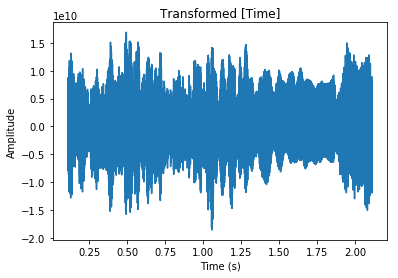

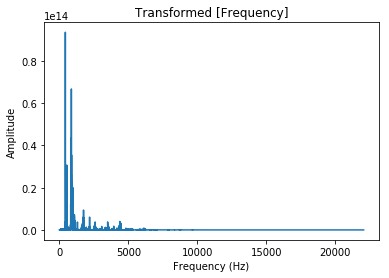

multiplication in the frequency domain corresponds to circular convolution, which assumes that the signal is periodic
When the signal is not periodic, we can avoid wrap-around by padding the signal with zeros.


In [5]:
# Convolution Thereom (multiplying spectrums in frequency domin will apply background sound to audio sample [assuming periodicity])
trans_spec = seg_spec * seg_vspec
trans_wave = make_wave(trans_spec)
print("By the Convolution Theorem, multiplication in the frequency domain corresponds to convolution in the time domain")
# Visualize
plt.plot(seg_ts[:-1],np.real(trans_wave))
plt.title('Transformed [Time]')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
plt.plot(seg_freq,np.abs(trans_spec))
plt.title('Transformed [Frequency]')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()
# Normalize and Listen
trans_wave /= np.amax(trans_wave)
sd.play(trans_wave,rate)
print("multiplication in the frequency domain corresponds to circular convolution, which assumes that the signal is periodic")
print("When the signal is not periodic, we can avoid wrap-around by padding the signal with zeros.")

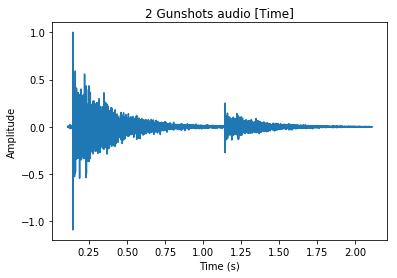

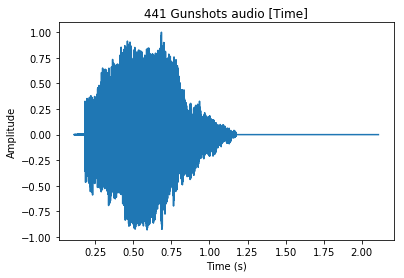

you can think of any wave as a series of samples, where each sample is an impulse with a different amplitude.


In [6]:
# ShiftScale (Another way of thinking of the convolution thereom --> convolution in the time domain)
# Visualize 2 guns
ssseg_data = shiftedScale(seg_data.copy(),seg_ts,shift = 1,factor = 0.5) + seg_data
ssseg_data /= np.amax(ssseg_data) # Normalize
plt.plot(seg_ts,np.real(ssseg_data))
plt.title('2 Gunshots audio [Time]')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
# listen
sd.play(ssseg_data,rate)
# Visualize 441 guns
dt     = 1/411
result = 0
for k in range(220):
    result += shiftedScale(seg_data.copy(),seg_ts,shift = dt*k,factor = 1)
result /= np.amax(result)
plt.plot(seg_ts,np.real(result))
plt.title('441 Gunshots audio [Time]')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()  
# Listen
time.sleep(2)
 # Normalize
result /= np.amax(np.abs(result))
sd.play(result,rate)
print('you can think of any wave as a series of samples, where each sample is an impulse with a different amplitude.')

DFT( f * g) = DFT( f )DFT(g)


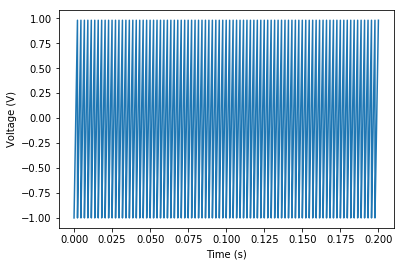

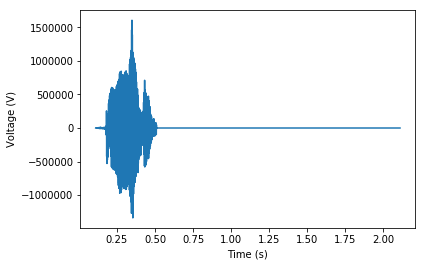

In [267]:
# Show how impulses can be aggregated to form background of sound
##    h[2] = f [0]g[2] + f [1]g[1] + f [2]g[0]
# where f is the sawtooth, g is the impulse response, and h is the sum of the shifted, scaled copies of g
print('DFT( f * g) = DFT( f )DFT(g)')
STts,STwave = genSawToothWave(amp = 1,freq = 441,dur = 0.2,frate = rate)
plt.plot(STts,STwave)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()
sd.play(STwave,rate)

total = 0
for t, y in zip(STts, STwave):
    total += shiftedScale(seg_data.copy(), seg_ts,shift=t, factor=y)
total /= np.amax(total)
plt.plot(seg_ts,total)
plt.title('')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()
sd.play(total,rate)

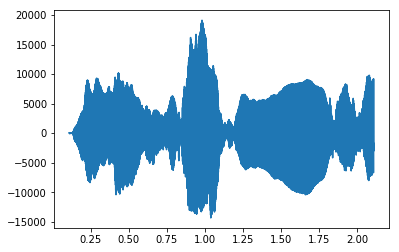

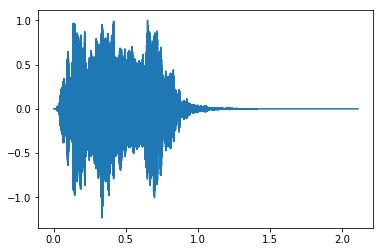

In summary, this is how you apply convolution thereom to merge a wave with impulse signal
by multiplying the frequency spectrums, or convolving in the time domain, we can reconstruct a background environment


In [322]:
# Returning back to violin
sd.play(seg_vdata,rate)
plt.plot(seg_vts,seg_vdata)
plt.show()
# now convolve it in time domain to add background sound
cwave = convolveWaves(seg_vdata,seg_data,domain="time")
cwave = cwave / np.amax(cwave)
nts   = np.linspace(0,seg_vts[-1],len(cwave))
plt.plot(nts,cwave)
plt.show()
time.sleep(2)
sd.play(cwave,rate)
print("In summary, this is how you apply convolution thereom to merge a wave with impulse signal")
print("by multiplying the frequency spectrums, or convolving in the time domain, we can reconstruct a background environment")